Tempo utilizado para fazer este Jupyter Notebook: ~3 horas.

Ambiente virtual: teste

# Uso do xarray

O exemplo abaixo foi obtido do site:

[https://docs.xarray.dev/en/stable/examples/weather-data.html](https://docs.xarray.dev/en/stable/examples/weather-data.html)

# Importação das bibliotecas

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

# Abertura do arquivo de precipitação

O arquivo de exemplo é um produto de precipitação estimado por satélite disponível no link abaixo:

[http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/](http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/)

Algumas informações:
* Os dados são diários e foram convertidos para acumulado mensal.
* Tempo utilizado: 36 meses compreendendo os anos de 2019, 2020 e 2021.
* Resolução espacial: 10 km.
* Domínio espacial: recorte sobre o Brasil.

In [3]:
ds = xr.open_dataset('../dados/NetCDF/MERGE_CPTEC_2019_2021.nc', decode_times=False)

# Conserta a data do arquivo

In [4]:
# Período de interesse. Tem que coincidir com o dado.
data_inicial='2019-01-01'  # Formato YYYY-MM-DD.
data_final='2021-12-01'  # Formato YYYY-MM-DD.

# Adicona atributos (units, Axis, long_name e standard_name) a dimensão "time".
ds['time'] = xr.date_range(data_inicial, data_final, name='time', freq='MS')
ds.time.attrs['units'] = "hours since 1800-01-01 00:00:0.0"
ds.time.attrs['Axis'] = "T"
ds.time.attrs['long_name'] = "Time"
ds.time.attrs['standard_name'] = "time" 

# Análise exploratório do arquivo

In [5]:
ds

<xarray.Dataset>
Dimensions:    (time: 36, longitude: 420, latitude: 410)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-12-01
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
Data variables:
    prec       (time, latitude, longitude) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.5 (https://mpime...
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0
    frequency:            mon
    history:              Wed May 11 13:48:42 2022: cdo -sellonlatbox,-76,-34...
    CDO:                  Climate Data Operators version 2.0.5 (https://mpime...

# Cálculo da climatologia

O **arquivo utilizado para calcular a climatologia tem apenas 3 anos** para evitar carregar um arquivo muito grande, mas o raciocínio é mesmo caso fosse utilizar 30 anos de dados.

## Caso 1:

Quando calcula-se a climatologia, é gerada uma nova variável em que a dimensão `time` possui apenas 12 tempos, variando de 1 a 12.

In [6]:
climatologia1 = ds.groupby("time.month").mean("time")

Visualizando o conteúdo da variável climatologia.

In [7]:
climatologia1

<xarray.Dataset>
Dimensions:    (longitude: 420, latitude: 410, month: 12)
Coordinates:
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prec       (month, latitude, longitude) float32 7.917 9.396 ... 367.2 364.9

Gerando o gráfico de climatologia para uma data em particular, isto é, o mês 7 (julho).

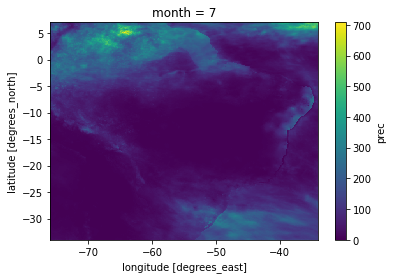

In [8]:
climatologia1.sel(month=7).prec.plot()
plt.show()

## Salvando o resultado no NetCDF

É possível salvar o resulto em um arquivo NetCDF utilizando `to_netcdf`.

O resultado a ser gravado é a `climatologia` e o nome do arquivo NetCDF é `clima_caso1.nc`.

É possível também informar o caminho onde se deseja salvar o arquivo.

In [9]:
# Definindo atributos da dimensão "month".
climatologia1.month.attrs['units'] = "hours since 1800-01-01 00:00:0.0"
climatologia1.month.attrs['Axis'] = "T"
climatologia1.month.attrs['long_name'] = "Time"
climatologia1.month.attrs['standard_name'] = "time" 

# Definindo atributos da variável "prec".
climatologia1.prec.attrs['_FillValue'] = -999

climatologia1.to_netcdf('clima_caso1.nc')

## Caso 2:

Neste segundo caso, supondo que o arquivo não possui todos os meses, e o usuário deseja definir uma data para calcular a climatologia.

In [10]:
# Abertura do arquivo.
ds2 = xr.open_dataset('../dados/NetCDF/MERGE_CPTEC_2019_2021.nc', decode_times=False)

# Período de interesse. Tem que coincidir com o dado.
data_inicial='2019-01-01'  # Formato YYYY-MM-DD.
data_final='2021-12-01'  # Formato YYYY-MM-DD.

# Adicona atributos (units, Axis, long_name e standard_name) a dimensão "time".
ds2['time'] = xr.date_range(data_inicial, data_final, name='time', freq='MS')
ds2.time.attrs['units'] = "hours since 1800-01-01 00:00:0.0"
ds2.time.attrs['Axis'] = "T"
ds2.time.attrs['long_name'] = "Time"
ds2.time.attrs['standard_name'] = "time"

O nome da variável a ser trabalhada é a `prec` e deseja-se calcular a climatologia ou média mensal utilizando apenas os anos de 2020 e 2021, ou seja, o ano de 2019 não nos interessa.

Para isso, será utilizado o `sel` em conjunto com o `slice` na dimensão `time`.

In [11]:
ds2.prec.sel(time=slice('2020-01-01', '2021-12-01'))

<xarray.DataArray 'prec' (time: 24, latitude: 410, longitude: 420)>
[4132800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2021-12-01
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
Attributes:
    long_name:   Precipitation
    units:       kg/m^2
    short_name:  PREC_surface
    level:       surface

Agora, basta calcular a climatologia utilizando um período de interesse.

In [12]:
climatologia2 = ds.groupby("time.month").mean("time")

Gerando o gráfico de climatologia para uma data em particular, isto é, o mês 7 (julho).

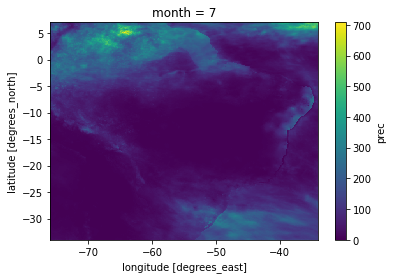

In [13]:
climatologia2.sel(month=7).prec.plot()
plt.show()

É o mesmo gráfico do Caso 1.

## Caso 3

Cálculo da climatologia sazonal

In [14]:
# Abertura do arquivo.
ds3 = xr.open_dataset('../dados/NetCDF/MERGE_CPTEC_2019_2021.nc', decode_times=False)

# Período de interesse. Tem que coincidir com o dado.
data_inicial='2019-01-01'  # Formato YYYY-MM-DD.
data_final='2021-12-01'  # Formato YYYY-MM-DD.

# Adicona atributos (units, Axis, long_name e standard_name) a dimensão "time".
ds3['time'] = xr.date_range(data_inicial, data_final, name='time', freq='MS')
ds3.time.attrs['units'] = "hours since 1800-01-01 00:00:0.0"
ds3.time.attrs['Axis'] = "T"
ds3.time.attrs['long_name'] = "Time"
ds3.time.attrs['standard_name'] = "time"

In [24]:
ds3

<xarray.Dataset>
Dimensions:    (time: 36, longitude: 420, latitude: 410)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-12-01
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
Data variables:
    prec       (time, latitude, longitude) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.5 (https://mpime...
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0
    frequency:            mon
    history:              Wed May 11 13:48:42 2022: cdo -sellonlatbox,-76,-34...
    CDO:                  Climate Data Operators version 2.0.5 (https://mpime...

In [36]:
# Climatologia sazonal.
clima_sazonal = ds3.prec.groupby('time.season').mean('time')

In [26]:
clima_sazonal

<xarray.DataArray 'prec' (season: 4, latitude: 410, longitude: 420)>
array([[[  3.7430556,   3.8819444,   4.1944447, ..., 184.28473  ,
         179.82639  , 178.70139  ],
        [  3.5138888,   3.5347223,   3.6527777, ..., 194.29861  ,
         189.84723  , 194.23611  ],
        [  3.0694444,   3.0902777,   3.3680556, ..., 207.97223  ,
         205.88889  , 205.625    ],
        ...,
        [100.052086 ,  84.65625  ,  90.40972  , ..., 164.76389  ,
         159.97223  , 156.1875   ],
        [ 96.85069  ,  88.125    ,  88.37153  , ..., 152.82639  ,
         153.59723  , 148.47917  ],
        [109.576385 , 101.635414 ,  83.49306  , ..., 137.54861  ,
         138.65973  , 138.28473  ]],

       [[ 25.472221 ,  25.395834 ,  25.61111  , ..., 106.048615 ,
         105.3125   , 103.763885 ],
        [ 25.020834 ,  26.194445 ,  25.67361  , ..., 104.36806  ,
         103.00694  , 100.673615 ],
        [ 23.534721 ,  25.020834 ,  25.82639  , ..., 100.3125   ,
         102.75694  ,  96.75694  ],
...
        [179.42361  , 161.33333  , 154.26389  , ...,  23.979166 ,
          22.79861  ,  22.979166 ],
        [181.45139  , 167.27083  , 165.13889  , ...,  18.930555 ,
          17.902779 ,  18.270834 ],
        [193.40277  , 182.29167  , 165.56944  , ...,  14.916667 ,
          14.979167 ,  14.520833 ]],

       [[  8.944445 ,   9.013889 ,   9.013889 , ..., 141.19444  ,
         140.71527  , 140.25     ],
        [  8.284722 ,   8.201389 ,   8.680555 , ..., 142.45833  ,
         140.31944  , 138.70139  ],
        [  8.104167 ,   8.138889 ,   8.965278 , ..., 144.56944  ,
         141.54861  , 142.72223  ],
        ...,
        [137.3125   , 117.791664 , 119.36806  , ..., 404.7361   ,
         411.15277  , 398.03473  ],
        [138.95139  , 127.11806  , 125.81944  , ..., 394.2361   ,
         389.83334  , 381.40973  ],
        [160.10417  , 152.94444  , 139.8125   , ..., 372.22916  ,
         382.20834  , 368.34027  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'

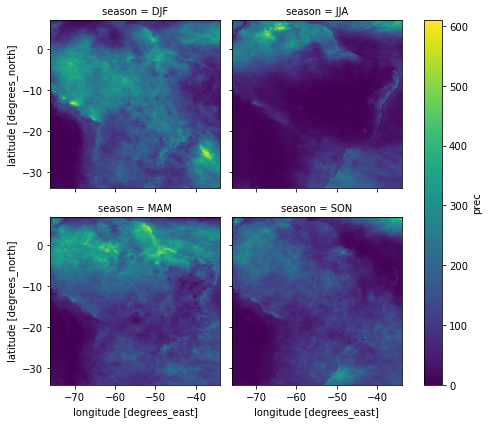

In [35]:
clima_sazonal.plot(col='season', col_wrap=2)

# Cálculo da anomalia

No caso da anomalia, são gerados 36 meses porque são 3 anos de dados mensais de precipitação.

Lembrando que climatologia1 é a média referente ao período 2019 a 2021.

In [15]:
anomalia = ds.groupby("time.month") - climatologia1

Visualizando o conteúdo da variável anomalia.

In [16]:
anomalia

<xarray.Dataset>
Dimensions:    (time: 36, longitude: 420, latitude: 410)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-12-01
  * longitude  (longitude) float64 -75.95 -75.85 -75.75 ... -34.25 -34.15 -34.05
  * latitude   (latitude) float64 -33.95 -33.85 -33.75 -33.65 ... 6.75 6.85 6.95
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prec       (time, latitude, longitude) float32 -6.292 -7.896 ... -15.06

Gerando o gráfico de anomalia para uma data em particular, isto é, 01/12/2021.

Lembrando, na climatologia foram gerados 12 tempos (1 a 12 meses). No caso da anomalia (desvio em relação à media ou climatologia) são gerados 36 meses ou tempos. Para visualizar cada mês, é necessário utilizar uma data como no exemplo abaixo.

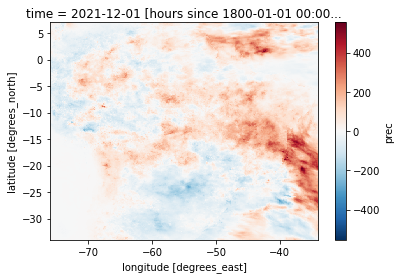

In [17]:
anomalia.sel(time='2021-12-01').prec.plot()
plt.show()